# Example: Use a First-Order Exponential Integrator Method to solve an IVP
The objective of this example is to familiarize students with using a [First-order Exponential Integrator method](https://en.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations) to solve a system of nonlinear ordinary differential equations. We'll use the three-gene memory circuit example from `Lab 9b` as our example problem.

<div>
    <center>
        <img src="figs/ThreeGene-Network.png" width="380"/>
    </center>
</div>

In this network, gene 1 is induced by an external activator. Gene 1 induces the expression of gene 2 and gene 3. 
However, gene 2 and gene 3 activate each other. The dynamics of the network are given by the following ordinary differential equations:

$$
\begin{equation}
\frac{dP_{i}}{dt} = \alpha_{i}\cdot{u}_{i}(\dots) - k_{d,i}\cdot{P_{i}},\quad{i=1,2,3}
\end{equation}
$$

where $P_{\star}$ denotes the gene product of gene $\star$, $u_{\star}(\dots)$ is the gene expression control functions, $\alpha_{\star}$ is the maximum transcription rate, and $k_{d,\star}$ is the degradation rate of protein $\star$.

## Setup
This example requires several external libraries and a function to compute the outer product. Let's download and install these packages and call our `Include.jl` file.

In [1]:
include("Include.jl");

  Activating project at `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-9/L9c`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-9/L9c/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-9/L9c/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-9/L9c/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-9/L9c/Manifest.toml`


## Prerequisites 
Before we solve the `three-gene` problem, we need to set up the parameters for the model and various other constants needed for the problem.

In [2]:
number_of_genes = 3;
ic = zeros(number_of_genes); # setup the initial conditions -
kd = 0.01*ones(number_of_genes); # setup degradation rate constants
dt = 0.1; # setup the time step
tspan = (0.0, 360.0, dt);

# setup data for the model, and then build the model -
α = zeros(number_of_genes + 1, number_of_genes + 1);
α[4,1] = 0.25;
α[1,2] = 0.25;
α[1,3] = 0.25;
α[2,3] = 0.15;
α[3,2] = 0.05;

K = zeros(number_of_genes + 1, number_of_genes + 1);
K[4,1] = 0.1;
K[1,2] = 0.1;
K[1,3] = 0.5;
K[2,3] = 0.1;
K[3,2] = 0.4;

n = zeros(number_of_genes + 1, number_of_genes + 1);
n[4,1] = 1;
n[1,2] = 2;
n[1,3] = 2;
n[2,3] = 2.5;
n[3,2] = 2;

# build the parameters dictionary -
parameters = Dict("α" => α, "K" => K, "n" => n, "kd" => kd, "activator" => 1.0); # what?

Dict{String, Any} with 5 entries:
  "activator" => 1.0
  "α"         => [0.0 0.25 0.25 0.0; 0.0 0.0 0.15 0.0; 0.0 0.05 0.0 0.0; 0.25 0…
  "K"         => [0.0 0.1 0.5 0.0; 0.0 0.0 0.1 0.0; 0.0 0.4 0.0 0.0; 0.1 0.0 0.…
  "kd"        => [0.01, 0.01, 0.01]
  "n"         => [0.0 2.0 2.0 0.0; 0.0 0.0 2.5 0.0; 0.0 2.0 0.0 0.0; 1.0 0.0 0.…

## Phase 1: Simulate the activation of the `three-gene` circuit
We've updated the signature of the `solve(...)` method that we originally developed in `Lab 9b` to be more like the standard ordinary differential equations package, the [DifferentialEquations.jl package](https://docs.sciml.ai/DiffEqDocs/stable/) which we'll use this afternoon, and in Problem Set 4.

```julia
function solve(balances::Function, tspan::Tuple{Float64,Float64,Float64}, initial::Array{Float64,1},
    parameters::Dict{String,Any}; solver::AbstractIVPSolverType = MyForwardEulerMethod())
```

* The new version of `solve(...)` takes the `balances::Function` as an argument, along with other data needed to solve the problem, i.e., the time span in the `tspan::Tuple{Float64, Float64, Float64}` argument, etc. Internally, we create a private instance of a `problem` container and pass it around to the `_solve(...)` implementations.
* For this problem, the `balances` function, which computes the right-hand side of the system of differential equations for the `three-gene` model, can be found in the [src/Memory.jl](src/Memory.jl) file.
* The `solve(...)` method returns a `Tuple` containing the time vector and solution array (time on the rows, states on the columns). Let's save these values in the `T1` and `X2` variables, respectively.

In [3]:
(T1,X1) = solve(balances, tspan, ic, parameters, solver = MyRungeKuttaMethod(0));

## Phase 2: Simulate the washout of the activator
Now, we'll simulate what happens if we wash out the activator, i.e., we remove the induction of `P1` in the circuit. To do this, we update the `parameters` dictionary, the initial condition `ic`, and the `tspan` arguments to the `solve(...)` function.

In [4]:
parameters["activator"] = 0.0;
ic = X1[end,:];
tspan = (T1[end], 2048.0, dt);

Now, we call the `solve(...)` function with the new arguments. This will run the simulation starting at the last point of the previous simulation when `activator = 0`. We'll save the simulation results in the `T2` and `X2` variables:

In [5]:
(T2,X2) = solve(balances, tspan, ic, parameters, solver = MyRungeKuttaMethod(0));

## Visualize
We want to plot both simulation phases on a single plot, so let's create a new time array variable `T` and state array `X` by appending `T2` to `T1`, and `X2` to `X1`. In the general case, we could use the [vcat function](https://docs.julialang.org/en/v1/base/arrays/#Base.vcat). The [vcat function](https://docs.julialang.org/en/v1/base/arrays/#Base.vcat) concatenates arrays or numbers vertically. This function is equivalent to `cat(A...; dims=1)` and to the short-hand syntax `[a; b; c]`.

In [6]:
T = [T1 ; T2]; # this is a short-hand way of appending T2 to T1
X = [X1 ; X2]; # this is a short-hand way of appending X2 to X1

`Unhide` the code-block below to see who we plotted the concentration of `P1, P2` and `P3` as a function time.

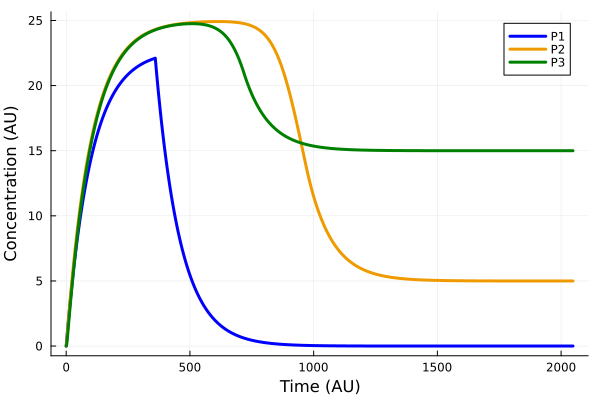

In [7]:
plot(T,X[:,1], label="P1", lw=3, color=:blue)
plot!(T,X[:,2], label="P2", lw=3, color=:orange2)
plot!(T,X[:,3], label="P3", lw=3, color=:green)
xlabel!("Time (AU)", fontsize=18)
ylabel!("Concentration (AU)", fontsize=18)

In [8]:
(U,Σ,V) = svd(X);

In [9]:
(number_of_rows, number_of_columns) = size(X);
M = zeros(number_of_rows, number_of_columns);

In [10]:
r = rank(X);
frames = Dict{Int64,Array{Float64,2}}();
for i ∈ 1:r
    M += Σ[i]*⊗(U[:,i],V[:,i]);
    frames[i] = M;
end

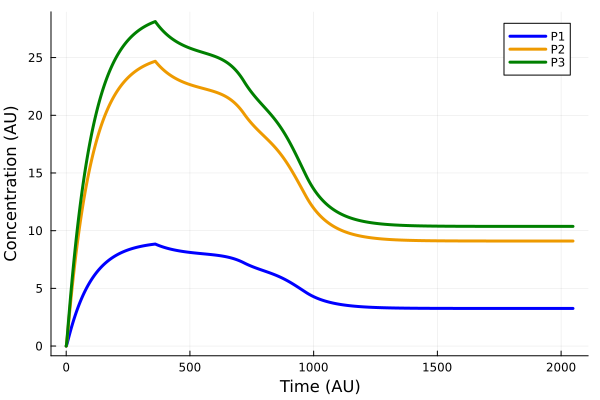

In [11]:
MD = frames[1];
plot(T,MD[:,1], label="P1", lw=3, color=:blue)
plot!(T,MD[:,2], label="P2", lw=3, color=:orange2)
plot!(T,MD[:,3], label="P3", lw=3, color=:green)
xlabel!("Time (AU)", fontsize=18)
ylabel!("Concentration (AU)", fontsize=18)